# Michael Pajares
## 12/17/2022
## CMP-262
### Project 4


Objective/Question to answer: Does the sentiment of the New York Times twitter account skew more negative or positive? 

In [ ]:
# Updating/installing deprecated packages
!pip install seaborn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [ ]:
!pip install nltk vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.3 MB/s 


In [ ]:
!pip install preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4476 sha256=3aeb967b749f50f296f81a97c96bac093cac657f5e920fdfbfb6666068eb8c57
  Stored in directory: /root/.cache/pip/wheels/e4/4e/bf/0ecf68aa10ee89d684d90437bd9f89ac19d5dc2921988bb59d
Successfully built preprocessor


In [ ]:
!pip install tweepy==4.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing necessary packages
import tweepy
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import preprocessor as prp
import geopy
import re 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

In [ ]:
# initializing bearer token
bearer_token = "placeholder"

In [ ]:
# setting up 
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)
nyt = client.get_user(username='nytimes',user_fields=['description', 'public_metrics'])
nyt_tweets = client.get_users_tweets(id=nyt.data.id, max_results=6)

In [ ]:
pag = tweepy.Paginator(client.get_users_tweets, nyt.data.id, max_results = 100)
nyt_tweets = []
for tweet in pag.flatten(limit=300):
    nyt_tweets.append(tweet)

nyt_tweet_text = [tweet.text for tweet in nyt_tweets]

nyt_tweet_text

['AMC has struggled to earn enough from streaming to make up for losses from its traditional cable business. It is a story widespread in the industry.  https://t.co/NXw9JCMt0E',
 'Read our full investigation on the Russian invasion plans that show that the military expected to triumph in Ukraine within days, but instead the “walk in the park” became a catastrophe for Russia: https://t.co/MGCbNpJ5TI',
 'On the day of the invasion, Putin set a trap for Russian business tycoons, putting them on TV “to tar everyone there,” as one described it. Those present were all hit by Western sanctions in the months that followed. \n\nHere are the rest of our takeaways: https://t.co/xgM3NJRRkY',
 'A senior Russian official told the CIA last month that Russia would not give up. One NATO member warned allies that Putin could accept the deaths or injuries of as many as 300,000 troops — roughly three times his estimated losses so far. https://t.co/xgM3NJRRkY',
 'The U.S. tried to stop Ukraine from killing

In [ ]:
def clean_tweet(tweet):
  # Remove hashtags, mentions, and URLs
  tweet = re.sub(r'#\S+', '', tweet)
  tweet = re.sub(r'@\S+', '', tweet)
  tweet = re.sub(r'https?://\S+', '', tweet)
  return tweet

nyt_tweet_text_cleaned = [clean_tweet(tweet) for tweet in nyt_tweet_text]

In [ ]:
nyt_tweet_text_cleaned

['AMC has struggled to earn enough from streaming to make up for losses from its traditional cable business. It is a story widespread in the industry.  ',
 'Read our full investigation on the Russian invasion plans that show that the military expected to triumph in Ukraine within days, but instead the “walk in the park” became a catastrophe for Russia: ',
 'On the day of the invasion, Putin set a trap for Russian business tycoons, putting them on TV “to tar everyone there,” as one described it. Those present were all hit by Western sanctions in the months that followed. \n\nHere are the rest of our takeaways: ',
 'A senior Russian official told the CIA last month that Russia would not give up. One NATO member warned allies that Putin could accept the deaths or injuries of as many as 300,000 troops — roughly three times his estimated losses so far. ',
 'The U.S. tried to stop Ukraine from killing a top Russian general, Valery Gerasimov, when American officials learned he was going to th

In [ ]:
# Import the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
# Initialize the SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sentiment_scores = [sentiment_analyzer.polarity_scores(tweet) for tweet in nyt_tweet_text_cleaned]

In [ ]:
# Iterate through the sentiment scores and determine the overall sentiment
sentiments = []
for score in sentiment_scores:
  # Check if the compound score is greater than 0
  if score['compound'] > 0:
    # If the score is positive, append 'positive' to the sentiments list
    sentiments.append('positive')
    # Check if the compound score is less than 0
  elif score['compound'] < 0:
    # If the score is negative, append 'negative' to the sentiments list
    sentiments.append('negative')
    # If the score is 0, it is neutral
  else:
    sentiments.append('neutral')

In [ ]:
sentiments_series = pd.Series(sentiments)

Text(0, 0.5, 'Count')

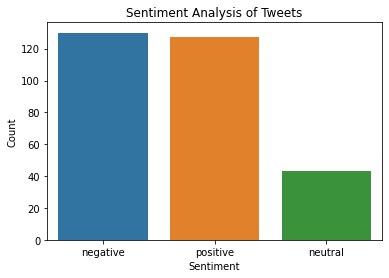

In [ ]:
# generating a countplot to display variance in sentiment for the tweets
sns.countplot(x=sentiments_series)
plt.title('Sentiment Analysis of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

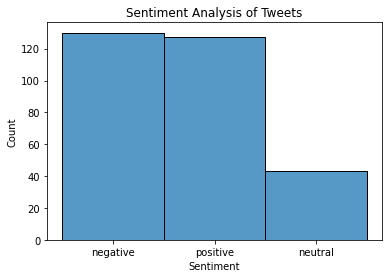

In [ ]:
# using a histogram instead
sns.histplot(data=sentiments_series)
plt.title('Sentiment Analysis of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')

## It would appear that overall, tweets posted by the NYT skew negative but not by a large margin. 

Let's generate a word cloud to display the most commonly used words.

In [ ]:
tweet_string = ' '.join(nyt_tweet_text)
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
filtered_tweets = []
for tweet in nyt_tweet_text:
  # Filtering the tweet by removing stop words and links
    filtered_tweet = [word for word in tweet.split() if word.lower() not in stop_words and not re.search(r'https\S+', word)]
    filtered_tweets.append(filtered_tweet)

In [ ]:
filtered_tweet_string = ' '.join([' '.join(tweet) for tweet in filtered_tweets])

In [ ]:
# generating word cloud
wordcloud = WordCloud().generate(filtered_tweet_string)

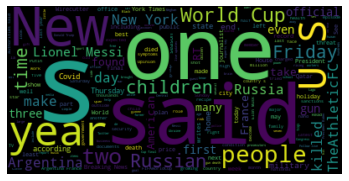

In [ ]:
# displaying word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There may be a few reasons why the sentiment analysis of tweets from the New York Times skewed more negative than positive.

It's important to note that the New York Times is a reputable news source that often reports on difficult or negative events, such as wars, natural disasters, or political scandals. As a result, their tweets may include more negative content than tweets from other sources.

It may also be the case that people are more likely to share negative news (negativity bias) on social media than positive news, which could lead to a higher proportion of negative tweets from the New York Times.

For future work, It could be valuable to conduct sentiment analysis on a larger data set of tweets from the New York Times and potentially other news sources in order to gain a more thorough understanding of this phenomenon.